In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rdm
from scipy import integrate, signal, optimize
from matplotlib import gridspec
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

Parameters

In [2]:
# parameters

phiR_min = 0.049 # Scott et al. 2010
phiR_max = 0.55 # Scott et al. 2010

a_n = 1e-3 # level to trigger negative feeback inhibition of amino acid supply, Scott et al. 2014
a_t = 1e-4 # amino acid level for efficient peptide elongation, Scott et al. 2014

mu = 2.5
alpha = 4.504
beta = 1.143

k_t0 = 2.6
kn0_high = 60
kn0_low = 4.8

### Figure 3A

Import Panlilio data to compare

In [21]:
# name directory for file import
root_dir = ['Panlilio Data/P5ter3/20160221/line_data','Panlilio Data/P5ter3/20160306/line_data']

df_KappaData = pd.DataFrame(columns=['tTrans','growthRateV2_0'])
for y in range(len(root_dir)):

    filenames = [(z[0], z[2]) for z in os.walk(root_dir[y])] # finds all filenames in directory

    # combining all data
    n_replicates = len(filenames[0][1][:]) # number of replicates in folder

    for x in range(n_replicates):

        # reading in dataset
        df = pd.read_csv(filenames[0][0] + '/' + filenames[0][1][x])
        # keeping only time and growth rate data
        df_crop = df[['tTrans','growthRateV2_0']]

        # appending data Data
        df_KappaData = df_KappaData.append(df_crop).reset_index(drop=True)

In [22]:
# Time-averaging Panlilio et al growth rate data

# Averaging growth rates from same timepoint
Time = df_KappaData['tTrans']

# averaging growth rates from same timepoint
t_unique = pd.unique(Time) /60 # converting to h from min
GRates = np.zeros(len(t_unique))

i=0
for x in t_unique:

    kappas_i = df_KappaData.loc[(df_KappaData['tTrans']/60 == x), ['growthRateV2_0']] # returning all growth rates for specified timepoint
    GRates[i] = np.mean(kappas_i) *60 # calculating mean growth rate for specified timepoint, converting to h^-1 from min^-1
    i+=1

pd_tUnique = pd.DataFrame(t_unique, columns=['t'])
pd_GRates = pd.DataFrame(GRates, columns=['GRate'])
GRate_concat = pd.concat([pd_tUnique,pd_GRates], axis=1, join='inner')

In [23]:
n_bins = 200 # number of bins for averaging
# set time range of analysis
t_min = -4
t_max = 8

time = np.linspace(t_min,t_max,n_bins+1)
GRate_ave = np.zeros(len(time))
GRate_std = np.zeros(len(time))
n_points = len(time)

i=0
while i < n_points-1:
    GRate_x = GRate_concat.loc[(GRate_concat['t'] > time[i]) & (GRate_concat['t'] < time[i+1]), ['GRate']]
    GRate_ave[i] = np.mean(GRate_x)
    GRate_std[i] = np.std(GRate_x)
    i+=1

# removing last timepoint becuase its not binned properly
time = time[0:-1]
GRate_ave = GRate_ave[0:-1]
GRate_std = GRate_std[0:-1]

Save results or import

In [26]:
# create dataframe
# df_time = pd.DataFrame(time, columns=['t'])
# df_GRate_ave = pd.DataFrame(GRate_ave, columns=['GRate'])
# df_GRate_std = pd.DataFrame(GRate_std, columns=['std'])

# save averaged data
# df_time.to_csv('Panlilio Data/time.csv', index=False)
# df_GRate_ave.to_csv('Panlilio Data/GRate.csv', index=False)
# df_GRate_std.to_csv('Panlilio Data/std.csv', index=False)

# importing
df_time = pd.read_csv('Panlilio Data/time.csv')
df_GRate_ave = pd.read_csv('Panlilio Data/GRate.csv')
df_GRate_std = pd.read_csv('Panlilio Data/std.csv')

Defining Coupled ODEs

In [28]:
# defining regulatory functions and their derivatives

f = lambda a: 1 / (1 + (a/a_n)**2) # regulatory function for k_n
f_prime = lambda a: -2*a/a_n**2 / (1 + (a/a_n)**2)**2 # derivative of f w.r.t. a

g = lambda a: (a/a_t)**2 / (1 + (a/a_t)**2) # regulatory function for k_t
g_prime = lambda a: 2*a/a_t**2 / (1 + (a/a_t)**2)**2 # derivative of g w.r.t. a

# f_R, the fraction of total cell synthesis capacity devoted to ribosome production
f_R = lambda a: (-f_prime(a)*g(a)*phiR_max + f(a)*g_prime(a)*phiR_min) / (-f_prime(a)*g(a) + f(a)*g_prime(a))

# f_X, fraction of cell synthesis capacity devoted to division protein production
f_X = lambda a: alpha*(phiR_max - f_R(a)) + beta

In [29]:
# defining growth rate function

def kappa(a, phi_R):

    k_t = k_t0 * g(a)

    k = k_t * (phi_R - phiR_min)
    return k

In [30]:
# ribosome mass fraction ODE (f_R variable)

def dphiR_dt(phi_R, t, a):

    k_t = k_t0 * g(a) # translational efficiency

    dpdt = k_t * (phi_R - phiR_min) * (f_R(a) - phi_R)
    return dpdt

In [31]:
def dXdt(X, t, a, phi_R, V):

    dxdt = f_X(a) * kappa(a, phi_R) * V - mu * X
    return dxdt

In [32]:
# amino acid concentration ODE (variable nutrient conc.(c))

def dAAdt(a, t, phi_R):

    k_n = k_n0(t) * f(a) # nutritional efficiency, depends on concentration of nutrients outside cell
    k_t = k_t0 * g(a) # translational efficiency

    dadt = k_n * (phiR_max - phi_R) - k_t * (phi_R - phiR_min)
    return dadt

In [33]:
def dVdt(V, t, a, phi_R):

    dvdt = kappa(a, phi_R) * V
    return dvdt

In [34]:
# packing coupled ODEs together to be solved by odeint

def odes(Species, t):

    phi_R,X,a,V = Species # Tuple unpakcing of each species, equivalent to phi_R = Species[0] // a = Species[1]

    phiR_ode = dphiR_dt(phi_R, t, a)
    X_ode = dXdt(X, t, a, phi_R, V)
    a_ode = dAAdt(a, t, phi_R)
    V_ode = dVdt(V, t, a, phi_R)

    dSpeciesdt = [phiR_ode,X_ode,a_ode,V_ode]
    return dSpeciesdt

Defining functions to calculate steady state initial conditions

In [35]:
# function for phi_R at steady state

def phiR_ss(a):

    k_n = k_n0(simulation_min) * f(a) # nutritional efficiency, depends on concentration of nutrients outside cell
    k_t = k_t0 * g(a) # translational efficiency

    return (k_n*phiR_max + k_t*phiR_min) / (k_n + k_t)

In [36]:
# function for calculating steady state conditions for given parameters

def func(x):
    return [phiR_ss(x[0]) - x[1], # x[0]=a, x[1]=phi_R
            f_R(x[0]) - x[1]]

Simulate and Plot functions

In [ ]:
# plot function

def PlotGrowth(phi_R, X, a, V, Time):

    # Plot Layout
    plt.rc('font', size=14.7) #controls default text size
    plt.rc('legend', fontsize=12) #fontsize of the legend
    fig, ax1 = plt.subplots(5,1, figsize=(10.2,13.2))
    # set height ratios for subplots
    gs = gridspec.GridSpec(5,1, height_ratios=[1,1,1,1.2,1.5])

    # Plot 1
    ax0 = plt.subplot(gs[0])
    ax0.plot(Time, k_n0(Time), color='g', linewidth=3)
    ax0.set_ylabel('Nutrient Conc., $c$', color='g')
    ax0.set_ylim(-20,80)
    ax0.set_yticks([])
    ax0.set_yticklabels([])
    # Adding twin axes
    ax1 = ax0.twinx()
    ax1.plot(Time, a, color='k')
    ax1.set_ylabel('Amino acid fraction, $a$')
    ax1.set_xlim(-4.7,7.5)

    # Plot 2
    fR = f_R(a)
    ax2 = plt.subplot(gs[1], sharex=ax0)
    ax2.plot(Time, fR, color='k', linestyle='--')
    ax2.set_ylabel('$f_R$')
    ax2.set_ylim(min(fR)-0.02, max(fR)+0.02)
    # Adding twin axes
    ax3 = ax2.twinx()
    ax3.set_ylabel('$\phi_R$', color='tab:red')
    ax3.plot(Time, phi_R, color='tab:red')
    ax3.tick_params(axis='y', labelcolor='tab:red')
    ax3.set_ylim(min(fR)-0.02, max(fR)+0.02)
    ax3.set_xlim(-4.7,7.5)

    # Plot 3
    fX = f_X(a)/250
    ax4 = plt.subplot(gs[2], sharex=ax1)
    ax4.plot(Time, fX, color='k', linestyle='--')
    ax4.set_ylabel('$f_X$')
    ax4.set_ylim(min(fX)-0.0005, max(fX)+0.0005)
    # Adding twin axes
    ax5 = ax4.twinx()
    ax5.set_ylabel('$k_P$ (h$^{-1}\mu$m$^{-3}$)', color='darkblue')
    ax5.plot(Time, f_X(a)*kappa(a, phi_R), color='darkblue')
    ax5.tick_params(axis='y', labelcolor='darkblue')
    ax5.set_ylim(0.8, 1.6)
    ax5.set_xlim(-4.7,7.5)

    # Plot 4
    ax6 = plt.subplot(gs[3])
    ax6.scatter(time[0:-1]-0.6, GRate_ave[0:-1], marker='d', s=60, color='mediumslateblue',  label='Panlilio et al.')
    ax6.plot(Time, kappa(a, phi_R), color='k', label='Model')
    plt.setp(ax6, ylabel='Growth Rate (h$^{-1}$)')
    ax6.legend(frameon=False)
    ax6.set_ylim(0.6,1.45)
    ax6.set_xlim(-4.7,7.5)

    # Plot 5
    ax7 = plt.subplot(gs[4], sharex=ax6)
    ax7.set_ylabel('Cell Volume ($\mu m^3$)')
    ax7.plot(Time, V, color='k')
    ax7.set_xlabel('Time (h)')
    # Adding twin axes
    ax8 = ax7.twinx()
    ax8.plot(Time, X, color='lightslategrey', linestyle='--')
    ax8.set_ylabel('Division Protein, $\\tilde{X}$', color='lightslategrey')
    ax8.tick_params(axis='y', labelcolor='lightslategrey')
    ax8.set_xlim(-4.7,7.5)

    plt.subplots_adjust(hspace=.0)
    # fig.savefig('Figures/Size Control Paper/5panel-revision.pdf', dpi=300, bbox_inches='tight')

In [38]:
# simulation implementation

def SimulateAndPlot(simulation_max, iterations):

    phi_R = np.zeros((iterations,1))
    phi_R[0] = phi_R0

    a = np.zeros((iterations,1))
    a[0] = a0

    X = np.zeros((iterations,1))
    X[0] = f_X(a0)*V0*0.2

    V = np.zeros((iterations,1))
    V[0] = V0

    t = np.linspace(simulation_min,simulation_max,iterations)

    i=1 # start at i=1 so a[i-1]=a0 and phi_R[i-1]=phi_R0
    while i < iterations:

        species_0 = [phi_R[i-1,0], X[i-1,0], a[i-1,0], V[i-1,0]] # packing initial conditions

        species = integrate.odeint(odes, species_0, t[i-1:i+1]) # solving for values at next timestep

        phi_R[i], X[i], a[i], V[i] = species[1,:] # unpacking and storing species values for new time step

        X_0 = 1 # amount of division proteins required to trigger division
        # if cell has added threshold volume amount, it will then divide
        if X[i-1] >= X_0:
            r = np.random.normal(0.5, 0.04) # drawing random value for volume allocation to daughter cell, taken from normal distribution
            V[i] = r * V[i-1] # cell volume is divided roughly in half
            X[i] = 0 # division protein concentration is equally distributed between daughter cells

        i +=1

    PlotGrowth(phi_R, X, a, V, t)

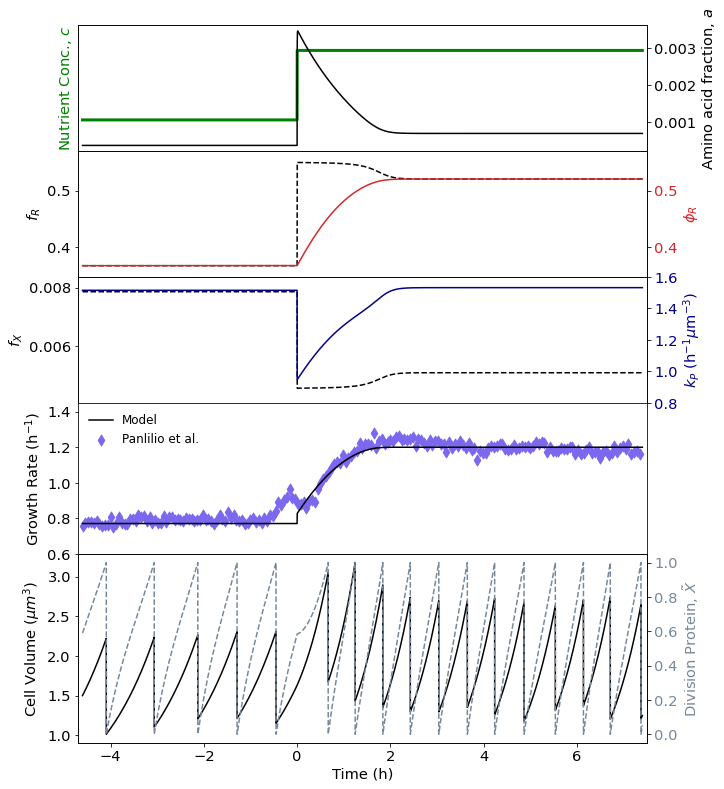

In [ ]:
offset = 0.6
simulation_min = -4 - offset
simulation_max = 8 - offset # in hrs
iterations = 40000 #number of simulation points

# concentration function
t_shift = 0 # time at which nutrient shift occurs, in hrs
k_n0 = lambda t: (kn0_high - kn0_low) * np.heaviside(t-t_shift,0.5) + kn0_low

# solving for initial conditions to produce steady state
root = optimize.fsolve(func, [1e-5, 0.2]) # requires guess of initial conditions
phi_R0 = root[1] # initial proteome fraction
a0 = root[0] # initial amin acid concentration
V0 = 1.5 # initial cell volume, in um^3

SimulateAndPlot(simulation_max, iterations)

### Figure 3B-D

Importing and appending data from Panlilio et al

In [25]:
# filenames for import
filenames = ['Panlilio Data/P5ter3/20160221/20160221_flat.csv','Panlilio Data/P5ter3/20160306/20160306_flat.csv']

df_Data = pd.DataFrame(columns=['t0Trans','t1Trans','divT','V0','V1'])
# t0Trans: time from shift, when cell was born
# t1Trans: time from shift, when cell divided
# divT: interdivisional time. n.b. t1Trans-T0 = divT + time_between_frames
# V0: (um^3) volume at birth
# V1: (um^3) volume before division

# combining replicates and selecting columns of interest
n_replicates = len(filenames) # number of replicates in folder

for x in range(n_replicates):

    # reading in dataset
    df = pd.read_csv(filenames[x])
    # keeping only time and growth rate data
    df_crop = df[['t0Trans','t1Trans','divT','V0','V1']]

    # appending data Data
    df_Data = df_Data.append(df_crop).reset_index(drop=True)

# calculating added volume and appending to df
df_Data['delta'] = df_Data['V1'] - df_Data['V0']
# calculating added-to-initial volume ratio
df_Data['ratio'] = df_Data['delta'] / df_Data['V0']

In [26]:
# defining the two regulatory function which compose dKappa_dt

def alpha_k(a,t):

    k_t = k_t0 * g(a)
    kt_prime = k_t0 * g_prime(a)
    k_n = k_n0(t) * f(a)

    return 1 + kt_prime / k_t + kt_prime * k_n / k_t**2

def beta_k(a,t):

    k_t = k_t0 * g(a)
    kt_prime = k_t0 * g_prime(a)
    k_n = k_n0(t) * f(a)

    return k_t * (f_R(a) - phiR_min) + kt_prime * k_n * (phiR_max - phiR_min) / k_t

In [27]:
# defining growth rate ODE

def dKappa_dt(kappa, t, a):

    return kappa * (beta_k(a,t) - alpha_k(a,t) * kappa)

In [28]:
def dXdt(X, t, a, kappa, V):

    dxdt = f_X(a) * kappa * V - mu * X
    return dxdt

In [29]:
# amino acid concentration ODE (variable nutrient conc.(c))

def dAAdt(a, t, kappa):

    k_n = k_n0(t) * f(a) # nutritional efficiency, depends on concentration of nutrients outside cell
    k_t = k_t0 * g(a) # translational efficiency

    dadt = k_n * (phiR_max - phiR_min) - (1 + k_n/k_t) * kappa
    return dadt

In [30]:
def dVdt(V, t, kappa):

    dvdt = kappa * V
    return dvdt

In [31]:
# packing coupled ODEs together to be solved by odeint

def odes(Species, t, del_K):

    kappa,X,a,V = Species # Tuple unpakcing of each species, equivalent to phi_R = Species[0] // a = Species[1]

    # simulating average growth dynamics of system
    kappa_ode = dKappa_dt(kappa, t, a)
    a_ode = dAAdt(a, t, kappa)

    # simulating cell-specific dynamics
    X_ode = dXdt(X, t, a, kappa, V)
    V_ode = dVdt(V, t, kappa + del_K)

    dSpeciesdt = [kappa_ode,X_ode,a_ode,V_ode]
    return dSpeciesdt

In [32]:
# function for phi_R at steady state

def kappa_ss(a):

    k_n = k_n0(0) * f(a) # nutritional efficiency, depends on concentration of nutrients outside cell
    k_t = k_t0 * g(a) # translational efficiency

    return k_n * (phiR_max - phiR_min) / (1 + k_n / k_t)

In [33]:
# function for calculating steady state conditions for given parameters

def func(x):
    return [kappa_ss(x[0]) - x[1], # x[0]=a, x[1]=kappa
            k_t0 * g(x[0]) * (f_R(x[0]) - phiR_min) - x[1]]

In [34]:
def std(kappa):
    a = 0.057
    b = 0.0064
    return (a * kappa/60 + b) * 60 # converting to h^-1

In [35]:
# plot function

def PlotGrowth(V, Time):

    # Plot Layout
    plt.figure(figsize=(10,5))
    plt.plot(Time, V)
    plt.xlabel('Time (hr)')
    plt.ylabel('Cell Volume ($\mu m^3$)')

In [36]:
# simulation implementation

def SimulateAndPlot(simulation_max, iterations, replicates):

    t = np.linspace(0,simulation_max,iterations)

    V = np.zeros((iterations,replicates))
    V_0 = np.zeros((iterations,replicates)) # birth volume
    delta_V = np.zeros((iterations,replicates))
    tau = np.zeros((iterations,replicates))
    kappa_cell = np.zeros((iterations,replicates))

    m=0
    while m < replicates:
        V[0,m] = rdm.randint(120,160)/100 # assigning random initial cell volume, in um^3
        V_0[0,m] = V[0,m]

        kappa = np.zeros((iterations,1))
        kappa[0] = kappa0

        del_K = np.random.normal(0, std(kappa0))
        if kappa0 + del_K < 0:
            del_K = -kappa0 + 1e-1
        kappa_cell[0,m] = kappa0 + del_K

        a = np.zeros((iterations,1))
        a[0] = a0

        X = np.zeros((iterations,1))
        X[0] = f_X(a0)*V_0[0,m]*0.2

        V_divide = V_0[0,m]
        t_divide = 0
        i=1 # start at i=1 so a[i-1]=a0 and phi_R[i-1]=phi_R0
        while i < iterations:

            species_0 = [kappa[i-1,0], X[i-1,0], a[i-1,0], V[i-1,m]] # packing initial conditions

            argtuple = (del_K,)
            species = integrate.odeint(odes, species_0, t[i-1:i+1], args=argtuple) # solving for values at next timestep

            kappa[i], X[i], a[i], V[i,m] = species[1,:] # unpacking and storing species values for new time step
            kappa_cell[i,m] = kappa[i] + del_K

            X_0 = 1 # amount of division proteins required to trigger division
            # if cell has added threshold volume amount, it will then divide
            if X[i-1] >= X_0:

                delta_V[i,m] = V[i-1,m] - V_divide
                tau[i,m] = t[i-1] - t_divide

                r = np.random.normal(0.5, 0.04) # drawing random value for volume allocation to daughter cell, taken from normal distribution
                V_divide = r * V[i-1,m] # cell volume is divided roughly in half
                t_divide = t[i]
                V[i,m] = V_0[i,m] = V_divide
                X[i] = 0 # division protein concentration is reset to zero
                del_K = np.random.normal(0, std(kappa[i]))
                if kappa[i] + del_K < 0:
                    del_K = -kappa[i] + 1e-1

            i +=1
        m +=1

    PlotGrowth(V, t)
    return V, V_0, t, delta_V, tau

### Our model

In [ ]:
f_X = lambda a: alpha*(phiR_max - f_R(a)) + beta

mu = 2.5
alpha = 4.504
beta = 1.143

k_t0 = 2.6
kn0_high = 60
kn0_low = 4.8

simulation_min = 0
simulation_max = 16 # in hrs

iterations = 15000 # number of simulation points per replicate
replicates = 400 # number of replicate simulations

# concentration function
t_shift = 8
k_n0 = lambda t: (kn0_high - kn0_low) * np.heaviside(t-t_shift,0.5) + kn0_low

# solving for initial conditions to produce steady state
root = optimize.fsolve(func, [1e-5, 0.2], args=(kn0_low,)) # requires guess of initial conditions
phi_R0 = root[1] # initial proteome fraction
a0 = root[0] # initial amin acid concentration

V, V_0, t, delta_V, tau = SimulateAndPlot(simulation_max, iterations, replicates)

Cleaning data to visualize $\Delta V$, $V_0$, and $\tau$

In [40]:
# creating dataframes for time, tau, deltaV, and V_0
df_tau = pd.DataFrame(tau, columns=range(replicates))
df_deltaV = pd.DataFrame(delta_V, columns=range(replicates))
df_V0 = pd.DataFrame(V_0, columns=range(replicates))
df_time = pd.DataFrame(t, columns=['t'])

# joining tau, deltaV, and V_0 data with time
df_concatTau = pd.concat([df_time,df_tau], axis=1, join='inner')
df_concatDelta = pd.concat([df_time,df_deltaV], axis=1, join='inner')
df_concatV0 = pd.concat([df_time,df_V0], axis=1, join='inner')

Saving simulation results and/or loading in previous results

In [57]:
# saving simulation results
# df_concatTau.to_csv('Simulation Results/tau.csv', index=False)
# df_concatDelta.to_csv('Simulation Results/delta.csv', index=False)
# df_concatV0.to_csv('Simulation Results/V0.csv', index=False)

# loading in saved results
df_concatTau = pd.read_csv('Simulation Results/tau.csv')
df_concatDelta = pd.read_csv('Simulation Results/delta.csv')
df_concatV0 = pd.read_csv('Simulation Results/V0.csv')
replicates = 400

Plotting $\tau$

In [58]:
# Simulation

# removing zeros from tau data and appending into one column
tau_clean = pd.DataFrame(columns=['t','tau'])
for x in range(replicates):

    tau_cut = df_concatTau.loc[(df_concatTau[str(x)] > 0), ['t',str(x)]] # removing zeros
    if tau_cut.size == 0:
        continue
    tau_cut = tau_cut.rename(columns={str(x):'tau'}).reset_index(drop=True) # renaming column so data can be appended to existing 'tau' column
    tau_cut = tau_cut.drop(0) # removes first row becuase value is not accurate due to random start volume
    tau_clean = tau_clean.append(tau_cut).reset_index(drop=True) # appending and reindexing

In [59]:
n_bins = 100 # number of bins for averaging
offset = 0.6 # accounts for lag between increase in growth and experimentally defined t_shift
t_min = 4 - offset # selecting time window for analysis
t_max = 16 - offset

time = np.linspace(t_min,t_max,n_bins+1)
tau_ave = np.zeros(len(time))
tau_std = np.zeros(len(time))
n_points = len(time)

i=0
while i < n_points-1:
    tau_x = tau_clean.loc[(tau_clean['t'] > time[i]) & (tau_clean['t'] < time[i+1]), ['tau']]
    tau_ave[i] = np.mean(tau_x)
    tau_std[i] = np.std(tau_x)
    i+=1

# changing time range to match plot from paper
time = time[0:-1] - t_shift + offset # removing last timepoint becuase its not binned properly
tau_ave = tau_ave[0:-1]
tau_std = tau_std[0:-1]

In [60]:
# Experimental

n_bins = 100 # number of bins for averaging
# set time range of analysis
t_min = -4
t_max = 8

timeExp = np.linspace(t_min,t_max,n_bins+1)
tauExp_ave = np.zeros(len(timeExp))
tauExp_std = np.zeros(len(timeExp))
n_points = len(timeExp)

i=0
while i < n_points-1:
    tau_x = df_Data.loc[(df_Data['t1Trans']/60 > timeExp[i]) & (df_Data['t1Trans']/60 < timeExp[i+1]), ['divT']]
    tauExp_ave[i] = np.mean(tau_x)
    tauExp_std[i] = np.std(tau_x)
    i+=1

timeExp = timeExp[0:-1]
tauExp_ave = tauExp_ave[0:-1]/60
tauExp_std = tauExp_std[0:-1]/60

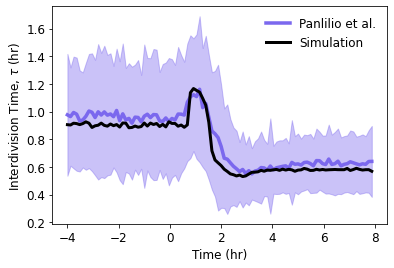

In [ ]:
plt.rc('font', size=12) #controls default text size
plt.rc('legend', fontsize=12) #fontsize of the legend
fig = plt.figure()

plt.plot(timeExp, tauExp_ave, label='Panlilio et al.', linewidth=3.5, color='mediumslateblue')
plt.fill_between(timeExp, tauExp_ave - tauExp_std, tauExp_ave + tauExp_std, alpha=0.4, color='mediumslateblue')
plt.plot(time4+0.6, tau_ave_reg, color='k', linewidth=3, label='Simulation')
plt.xlabel('Time (hr)')
plt.ylabel('Interdivision Time, $\u03C4$ (hr)')
plt.legend(frameon=False)
plt.show()

Plotting $\Delta$

In [47]:
# removing zeros from deltaV data and appending into one column
deltaV_clean = pd.DataFrame(columns=['t','delta V'])
for x in range(replicates):

    delta_cut = df_concatDelta.loc[(df_concatDelta[str(x)] > 0), ['t',str(x)]] # removing zeros
    if delta_cut.size == 0:
        continue
    delta_cut = delta_cut.rename(columns={str(x):'delta V'}).reset_index(drop=True) # renaming column so data can be appended to existing 'delta V' column
    delta_cut = delta_cut.drop(0) # removes first row becuase value is not accurate due to random start volume
    deltaV_clean = deltaV_clean.append(delta_cut).reset_index(drop=True) # appending and reindexing

In [48]:
n_bins = 100 # number of bins for averaging
t_min = 4 - offset # selecting time window for analysis
t_max = 16 - offset

time = np.linspace(t_min,t_max,n_bins+1)
deltaV_ave = np.zeros(len(time))
deltaV_std = np.zeros(len(time))
n_points = len(time)

i=0
while i < n_points-1:
    deltaV_x = deltaV_clean.loc[(deltaV_clean['t'] > time[i]) & (deltaV_clean['t'] < time[i+1]), ['delta V']]
    deltaV_ave[i] = np.mean(deltaV_x)
    deltaV_std[i] = np.std(deltaV_x)
    i+=1

# changing time range to match plot from paper
time = time[0:-1] - t_shift + offset # removing last timepoint becuase its not binned properly

deltaV_ave = deltaV_ave[0:-1]
deltaV_std = deltaV_std[0:-1]

In [49]:
# Experimental

n_bins = 100 # number of bins for averaging
# set time range of analysis
t_min = -4
t_max = 8

timeExp = np.linspace(t_min,t_max,n_bins+1)
deltaExp_ave = np.zeros(len(timeExp))
deltaExp_std = np.zeros(len(timeExp))
n_points = len(timeExp)

i=0
while i < n_points-1:
    delta_x = df_Data.loc[(df_Data['t1Trans']/60 > timeExp[i]) & (df_Data['t1Trans']/60 < timeExp[i+1]), ['delta']]
    deltaExp_ave[i] = np.mean(delta_x)
    deltaExp_std[i] = np.std(delta_x)
    i+=1

# removing last timepoint becuase its not binned properly
timeExp = timeExp[0:-1]
deltaExp_ave = deltaExp_ave[0:-1]
deltaExp_std = deltaExp_std[0:-1]

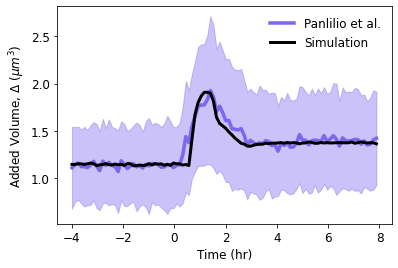

In [ ]:
plt.rc('font', size=12) #controls default text size
plt.rc('legend', fontsize=12) #fontsize of the legend
fig = plt.figure()

plt.plot(timeExp, deltaExp_ave, label='Panlilio et al.', linewidth=3.5, color='mediumslateblue')
plt.fill_between(timeExp, deltaExp_ave - deltaExp_std, deltaExp_ave + deltaExp_std, alpha=0.4, color='mediumslateblue')
plt.plot(time4+0.6, deltaV_ave_reg, color='k', linewidth=3, label='Simulation')
plt.xlabel('Time (hr)')
plt.ylabel('Added Volume, $\Delta$ ($\mu m^3$)')
plt.legend(frameon=False)
plt.show()

Plotting $\Delta V / V_0$

In [51]:
# removing zeros from tau data and appending into one column
V0_clean = pd.DataFrame(columns=['t','V_0'])
for x in range(replicates):

    V0_cut = df_concatV0.loc[(df_concatV0[str(x)] > 0), ['t',str(x)]] # removing zeros
    if V0_cut.size == 0:
        continue
    V0_cut = V0_cut.rename(columns={str(x):'V_0'}).reset_index(drop=True) # renaming column so data can be appended to existing 'tau' column
    V0_cut = V0_cut.drop(0) # removes first row becuase value is not accurate due to random start volume
    if V0_cut.size == 0:
        continue
    V0_cut = V0_cut.drop(len(V0_cut)) # remove last row because point has no corresponding deltaV
    V0_clean = V0_clean.append(V0_cut).reset_index(drop=True) # appending and reindexing

In [52]:
# calculating deltaV / V0
V_ratio = pd.DataFrame(deltaV_clean['delta V'] / V0_clean['V_0'], columns=['V ratio']) # pairing previous timepoint V0 with current timepoint deltaV (matching corresponding birth and division datapoints)
Vratio_df = pd.concat([deltaV_clean['t'],V_ratio], axis=1, join='inner')

In [53]:
n_bins = 80 # number of bins for averaging
t_min = 4 - offset
t_max = 16 - offset

time = np.linspace(t_min,t_max,n_bins+1)
Vratio_ave = np.zeros(len(time))
Vratio_std = np.zeros(len(time))
n_points = len(time)

i=0
while i < n_points-1:
    Vratio_i = Vratio_df.loc[(Vratio_df['t'] > time[i]) & (Vratio_df['t'] < time[i+1]), ['V ratio']]
    Vratio_ave[i] = np.mean(Vratio_i)
    Vratio_std[i] = np.std(Vratio_i)
    i+=1

# changing time range to match plot from paper
time = time[0:-1] - t_shift + offset # removing last timepoint becuase its not binned properly

Vratio_ave = Vratio_ave[0:-1]
Vratio_std = Vratio_std[0:-1]

In [54]:
# experimental

n_bins = 80 # number of bins for averaging
# set time range of analysis
t_min = -4
t_max = 8

timeExp = np.linspace(t_min,t_max,n_bins+1)
ratio_ave = np.zeros(len(timeExp))
ratio_std = np.zeros(len(timeExp))
n_points = len(timeExp)

i=0
while i < n_points-1:
    ratio_x = df_Data.loc[(df_Data['t1Trans']/60 > timeExp[i]) & (df_Data['t1Trans']/60 < timeExp[i+1]), ['ratio']]
    ratio_ave[i] = np.mean(ratio_x)
    ratio_std[i] = np.std(ratio_x)
    i+=1

# removing last timepoint becuase its not binned properly
timeExp = timeExp[0:-1]
ratio_ave = ratio_ave[0:-1]
ratio_std = ratio_std[0:-1]

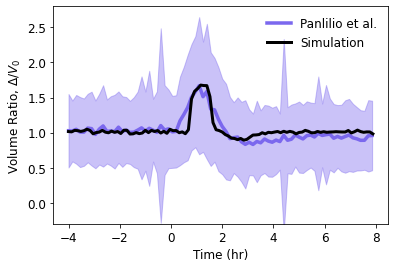

In [ ]:
plt.rc('font', size=12) #controls default text size
plt.rc('legend', fontsize=12) #fontsize of the legend
fig = plt.figure()

plt.plot(timeExp, ratio_ave, label='Panlilio et al.', linewidth=3.5, color='mediumslateblue')
plt.fill_between(timeExp, ratio_ave - ratio_std, ratio_ave + ratio_std, alpha=0.4, color='mediumslateblue')
plt.plot(time4+0.6, Vratio_ave_reg, color='k', linewidth=3, label='Simulation')
plt.xlabel('Time (hr)')
plt.ylabel('Volume Ratio, $\Delta / V_0$')
plt.legend(frameon=False)
plt.ylim(-0.3,2.8)
plt.show()
# fig.savefig('Figures/Size Control Paper/panlilio-volRatio-pptx.pdf', dpi=300, bbox_inches='tight')

### Alternate allocation strategies

#### Constant allocation

In [ ]:
# f_X, fraction of cell synthesis capacity devoted to division protein production
f_X = lambda a: 0.897 + a*0

mu = 0
k_t0 = 2.6
kn0_high = 60
kn0_low = 4.8

simulation_min = 0
simulation_max = 16 # in hrs

iterations = 15000 # number of simulation points per replicate
replicates = 400 # number of replicate simulations

# concentration function
t_shift = 8
k_n0 = lambda t: (kn0_high - kn0_low) * np.heaviside(t-t_shift,0.5) + kn0_low

# solving for initial conditions to produce steady state
root = optimize.fsolve(func, [1e-5, 0.2], args=(kn0_low,)) # requires guess of initial conditions
phi_R0 = root[1] # initial proteome fraction
a0 = root[0] # initial amin acid concentration

V, V_0, t, delta_V, tau = SimulateAndPlot(simulation_max, iterations, replicates)

Cleaning data to visualize $\Delta V$, $V_0$, and $\tau$

In [ ]:
# creating dataframes for time, tau, deltaV, and V_0
df_tau = pd.DataFrame(tau, columns=range(replicates))
df_deltaV = pd.DataFrame(delta_V, columns=range(replicates))
df_V0 = pd.DataFrame(V_0, columns=range(replicates))
df_time = pd.DataFrame(t, columns=['t'])

# joining tau, deltaV, and V_0 data with time
df_concatTau = pd.concat([df_time,df_tau], axis=1, join='inner')
df_concatDelta = pd.concat([df_time,df_deltaV], axis=1, join='inner')
df_concatV0 = pd.concat([df_time,df_V0], axis=1, join='inner')

Saving simulation results and/or loading in previous results

In [ ]:
# saving simulation results
# df_concatTau.to_csv('Cell_size-results/reviewer/tau-const.csv', index=False)
# df_concatDelta.to_csv('Cell_size-results/reviewer/delta-const.csv', index=False)
# df_concatV0.to_csv('Cell_size-results/reviewer/V0-const.csv', index=False)

# loading in previous results
df_concatTau = pd.read_csv('Cell_size-results/reviewer/tau-const.csv')
df_concatDelta = pd.read_csv('Cell_size-results/reviewer/delta-const.csv')
df_concatV0 = pd.read_csv('Cell_size-results/reviewer/V0-const.csv')
replicates = 400

Plotting $\tau$

In [ ]:
# Simulation

# NOTE: use str(x) if loading, just x if just ran simulation

# removing zeros from tau data and appending into one column
tau_clean = pd.DataFrame(columns=['t','tau'])
for x in range(replicates):

    tau_cut = df_concatTau.loc[(df_concatTau[str(x)] > 0), ['t', str(x)]] # removing zeros
    tau_cut = tau_cut.rename(columns={str(x):'tau'}).reset_index(drop=True) # renaming column so data can be appended to existing 'tau' column
    tau_cut = tau_cut.drop(0) # removes first row becuase value is not accurate due to random start volume
    tau_clean = tau_clean.append(tau_cut).reset_index(drop=True) # appending and reindexing

In [ ]:
n_bins = 100 # number of bins for averaging
t_min = 4 - 0.6  # selecting time window for analysis
t_max = 16 - 0.6

time = np.linspace(t_min,t_max,n_bins+1)
tau_ave = np.zeros(len(time))
tau_std = np.zeros(len(time))
n_points = len(time)

i=0
while i < n_points-1:
    tau_x = tau_clean.loc[(tau_clean['t'] > time[i]) & (tau_clean['t'] < time[i+1]), ['tau']]
    tau_ave[i] = np.mean(tau_x)
    tau_std[i] = np.std(tau_x)
    i+=1

# changing time range to match plot from paper
time4 = time[0:-1] - t_shift # removing last timepoint becuase its not binned properly
tau_ave_const = tau_ave[0:-1]
tau_std_const = tau_std[0:-1]

In [ ]:
# Experimental

n_bins = 100 # number of bins for averaging
# set time range of analysis
t_min = -4
t_max = 8

timeExp = np.linspace(t_min,t_max,n_bins+1)
tauExp_ave = np.zeros(len(timeExp))
tauExp_std = np.zeros(len(timeExp))
n_points = len(timeExp)

i=0
while i < n_points-1:
    tau_x = df_Data.loc[(df_Data['t1Trans']/60 > timeExp[i]) & (df_Data['t1Trans']/60 < timeExp[i+1]), ['divT']]
    tauExp_ave[i] = np.mean(tau_x)
    tauExp_std[i] = np.std(tau_x)
    i+=1

timeExp = timeExp[0:-1]
tauExp_ave = tauExp_ave[0:-1]/60
tauExp_std = tauExp_std[0:-1]/60

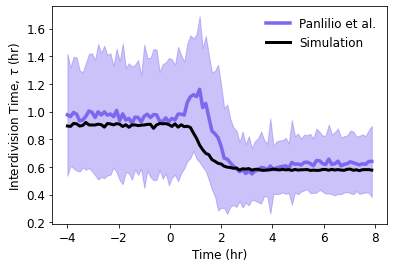

In [ ]:
plt.rc('font', size=12) #controls default text size
plt.rc('legend', fontsize=12) #fontsize of the legend
fig = plt.figure()

plt.plot(timeExp, tauExp_ave, label='Panlilio et al.', linewidth=3.5, color='mediumslateblue')
plt.fill_between(timeExp, tauExp_ave - tauExp_std, tauExp_ave + tauExp_std, alpha=0.4, color='mediumslateblue')
plt.plot(time4+0.6, tau_ave_const, color='k', linewidth=3, label='Simulation')
plt.xlabel('Time (hr)')
plt.ylabel('Interdivision Time, $\u03C4$ (hr)')
plt.legend(frameon=False)
plt.show()
# fig.savefig('Figures/Size Control Paper/panlilio-tau-pptx.pdf', dpi=300, bbox_inches='tight')

Plotting $\Delta$

In [ ]:
# removing zeros from deltaV data and appending into one column
deltaV_clean = pd.DataFrame(columns=['t','delta V'])
for x in range(replicates):

    delta_cut = df_concatDelta.loc[(df_concatDelta[str(x)] > 0), ['t',str(x)]] # removing zeros
    delta_cut = delta_cut.rename(columns={str(x):'delta V'}).reset_index(drop=True) # renaming column so data can be appended to existing 'delta V' column
    delta_cut = delta_cut.drop(0) # removes first row becuase value is not accurate due to random start volume
    deltaV_clean = deltaV_clean.append(delta_cut).reset_index(drop=True) # appending and reindexing

In [ ]:
n_bins = 100 # number of bins for averaging
t_min = 4 - 0.6 # selecting time window for analysis
t_max = 16 - 0.6

time = np.linspace(t_min,t_max,n_bins+1)
deltaV_ave = np.zeros(len(time))
deltaV_std = np.zeros(len(time))
n_points = len(time)

i=0
while i < n_points-1:
    deltaV_x = deltaV_clean.loc[(deltaV_clean['t'] > time[i]) & (deltaV_clean['t'] < time[i+1]), ['delta V']]
    deltaV_ave[i] = np.mean(deltaV_x)
    deltaV_std[i] = np.std(deltaV_x)
    i+=1

# changing time range to match plot from paper
time4 = time[0:-1] - t_shift # removing last timepoint becuase its not binned properly

deltaV_ave_const = deltaV_ave[0:-1]
deltaV_std_const = deltaV_std[0:-1]

In [ ]:
# Experimental

n_bins = 100 # number of bins for averaging
# set time range of analysis
t_min = -4
t_max = 8

timeExp = np.linspace(t_min,t_max,n_bins+1)
deltaExp_ave = np.zeros(len(timeExp))
deltaExp_std = np.zeros(len(timeExp))
n_points = len(timeExp)

i=0
while i < n_points-1:
    delta_x = df_Data.loc[(df_Data['t1Trans']/60 > timeExp[i]) & (df_Data['t1Trans']/60 < timeExp[i+1]), ['delta']]
    deltaExp_ave[i] = np.mean(delta_x)
    deltaExp_std[i] = np.std(delta_x)
    i+=1

# removing last timepoint becuase its not binned properly
timeExp = timeExp[0:-1]
deltaExp_ave = deltaExp_ave[0:-1]
deltaExp_std = deltaExp_std[0:-1]

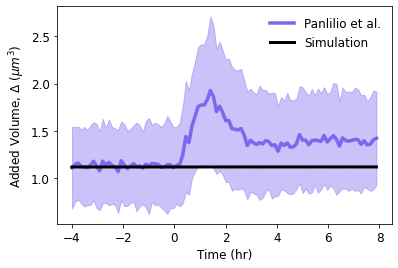

In [ ]:
plt.rc('font', size=12) #controls default text size
plt.rc('legend', fontsize=12) #fontsize of the legend
fig = plt.figure()

plt.plot(timeExp, deltaExp_ave, label='Panlilio et al.', linewidth=3.5, color='mediumslateblue')
plt.fill_between(timeExp, deltaExp_ave - deltaExp_std, deltaExp_ave + deltaExp_std, alpha=0.4, color='mediumslateblue')
plt.plot(time4+0.6, deltaV_ave_const, color='k', linewidth=3, label='Simulation')
plt.xlabel('Time (hr)')
plt.ylabel('Added Volume, $\Delta$ ($\mu m^3$)')
plt.legend(frameon=False)
plt.show()
# fig.savefig('Figures/Size Control Paper/panlilio-delta-pptx.pdf', dpi=300, bbox_inches='tight')

Plotting $V_0$

In [ ]:
# removing zeros from tau data and appending into one column
V0_clean = pd.DataFrame(columns=['t','V_0'])
for x in range(replicates):

    V0_cut = df_concatV0.loc[(df_concatV0[str(x)] > 0), ['t',str(x)]] # removing zeros
    V0_cut = V0_cut.rename(columns={str(x):'V_0'}).reset_index(drop=True) # renaming column so data can be appended to existing 'tau' column
    V0_cut = V0_cut.drop(0) # removes first row becuase value is not accurate due to random start volume
    V0_cut = V0_cut.drop(len(V0_cut)) # remove last row because point has no corresponding deltaV
    V0_clean = V0_clean.append(V0_cut).reset_index(drop=True) # appending and reindexing

Plotting $\Delta V / V_0$

In [ ]:
# calculating deltaV / V0
V_ratio = pd.DataFrame(deltaV_clean['delta V'] / V0_clean['V_0'], columns=['V ratio']) # pairing previous timepoint V0 with current timepoint deltaV (matching corresponding birth and division datapoints)
Vratio_df = pd.concat([deltaV_clean['t'],V_ratio], axis=1, join='inner')

In [ ]:
n_bins = 100 # number of bins for averaging
t_min = 4 - 0.6
t_max = 16 - 0.6

time = np.linspace(t_min,t_max,n_bins+1)
Vratio_ave = np.zeros(len(time))
Vratio_std = np.zeros(len(time))
n_points = len(time)

i=0
while i < n_points-1:
    Vratio_i = Vratio_df.loc[(Vratio_df['t'] > time[i]) & (Vratio_df['t'] < time[i+1]), ['V ratio']]
    Vratio_ave[i] = np.mean(Vratio_i)
    Vratio_std[i] = np.std(Vratio_i)
    i+=1

# changing time range to match plot from paper
time4 = time[0:-1] - t_shift # removing last timepoint becuase its not binned properly

Vratio_ave_const = Vratio_ave[0:-1]
Vratio_std_const = Vratio_std[0:-1]

In [ ]:
# experimental

n_bins = 80 # number of bins for averaging
# set time range of analysis
t_min = -4
t_max = 8

timeExp = np.linspace(t_min,t_max,n_bins+1)
ratio_ave = np.zeros(len(timeExp))
ratio_std = np.zeros(len(timeExp))
n_points = len(timeExp)

i=0
while i < n_points-1:
    ratio_x = df_Data.loc[(df_Data['t1Trans']/60 > timeExp[i]) & (df_Data['t1Trans']/60 < timeExp[i+1]), ['ratio']]
    ratio_ave[i] = np.mean(ratio_x)
    ratio_std[i] = np.std(ratio_x)
    i+=1

# removing last timepoint becuase its not binned properly
timeExp = timeExp[0:-1]
ratio_ave = ratio_ave[0:-1]
ratio_std = ratio_std[0:-1]

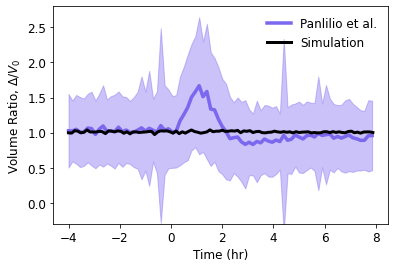

In [ ]:
plt.rc('font', size=12) #controls default text size
plt.rc('legend', fontsize=12) #fontsize of the legend
fig = plt.figure()

plt.plot(timeExp, ratio_ave, label='Panlilio et al.', linewidth=3.5, color='mediumslateblue')
plt.fill_between(timeExp, ratio_ave - ratio_std, ratio_ave + ratio_std, alpha=0.4, color='mediumslateblue')
plt.plot(time4+0.6, Vratio_ave_const, color='k', linewidth=3, label='Simulation')
plt.xlabel('Time (hr)')
plt.ylabel('Volume Ratio, $\Delta / V_0$')
plt.legend(frameon=False)
plt.ylim(-0.3,2.8)
plt.show()
# fig.savefig('Figures/Size Control Paper/panlilio-volRatio-pptx.pdf', dpi=300, bbox_inches='tight')

### Allocation proportional to ribosome production

In [ ]:
# f_X, fraction of cell synthesis capacity devoted to division protein production
f_X = lambda a: alpha*f_R(a) + beta

mu = 0
alpha = 0.656
beta = 0.656

k_t0 = 2.6
kn0_high = 60
kn0_low = 4.8

simulation_min = 0
simulation_max = 16 # in hrs

iterations = 15000 # number of simulation points per replicate
replicates = 400 # number of replicate simulations

# concentration function
t_shift = 8
k_n0 = lambda t: (kn0_high - kn0_low) * np.heaviside(t-t_shift,0.5) + kn0_low

# solving for initial conditions to produce steady state
root = optimize.fsolve(func, [1e-5, 0.2], args=(kn0_low,)) # requires guess of initial conditions
phi_R0 = root[1] # initial proteome fraction
a0 = root[0] # initial amin acid concentration

V, V_0, t, delta_V, tau = SimulateAndPlot(simulation_max, iterations, replicates)

##### Simulation Analysis

Cleaning data to visualize $\Delta V$, $V_0$, and $\tau$

In [ ]:
# creating dataframes for time, tau, deltaV, and V_0
df_tau = pd.DataFrame(tau, columns=range(replicates))
df_deltaV = pd.DataFrame(delta_V, columns=range(replicates))
df_V0 = pd.DataFrame(V_0, columns=range(replicates))
df_time = pd.DataFrame(t, columns=['t'])

# joining tau, deltaV, and V_0 data with time
df_concatTau = pd.concat([df_time,df_tau], axis=1, join='inner')
df_concatDelta = pd.concat([df_time,df_deltaV], axis=1, join='inner')
df_concatV0 = pd.concat([df_time,df_V0], axis=1, join='inner')

Saving simulation results and/or loading in previous results

In [ ]:
# saving simulation results
# df_concatTau.to_csv('Cell_size-results/reviewer/tau-inverse.csv', index=False)
# df_concatDelta.to_csv('Cell_size-results/reviewer/delta-inverse.csv', index=False)
# df_concatV0.to_csv('Cell_size-results/reviewer/V0-inverse.csv', index=False)

# loading in previous results
df_concatTau = pd.read_csv('Cell_size-results/reviewer/tau-inverse.csv')
df_concatDelta = pd.read_csv('Cell_size-results/reviewer/delta-inverse.csv')
df_concatV0 = pd.read_csv('Cell_size-results/reviewer/V0-inverse.csv')
replicates = 400

Plotting $\tau$

In [ ]:
# Simulation

# removing zeros from tau data and appending into one column
tau_clean = pd.DataFrame(columns=['t','tau'])
for x in range(replicates):

    tau_cut = df_concatTau.loc[(df_concatTau[str(x)] > 0), ['t',str(x)]] # removing zeros
    tau_cut = tau_cut.rename(columns={str(x):'tau'}).reset_index(drop=True) # renaming column so data can be appended to existing 'tau' column
    tau_cut = tau_cut.drop(0) # removes first row becuase value is not accurate due to random start volume
    tau_clean = tau_clean.append(tau_cut).reset_index(drop=True) # appending and reindexing

In [ ]:
n_bins = 100 # number of bins for averaging
t_min = 4 - 0.6  # selecting time window for analysis
t_max = 16 - 0.6

time = np.linspace(t_min,t_max,n_bins+1)
tau_ave = np.zeros(len(time))
tau_std = np.zeros(len(time))
n_points = len(time)

i=0
while i < n_points-1:
    tau_x = tau_clean.loc[(tau_clean['t'] > time[i]) & (tau_clean['t'] < time[i+1]), ['tau']]
    tau_ave[i] = np.mean(tau_x)
    tau_std[i] = np.std(tau_x)
    i+=1

# changing time range to match plot from paper
time4 = time[0:-1] - t_shift # removing last timepoint becuase its not binned properly
tau_ave_inverse = tau_ave[0:-1]
tau_std_inverse = tau_std[0:-1]

In [ ]:
# Experimental

n_bins = 100 # number of bins for averaging
# set time range of analysis
t_min = -4
t_max = 8

timeExp = np.linspace(t_min,t_max,n_bins+1)
tauExp_ave = np.zeros(len(timeExp))
tauExp_std = np.zeros(len(timeExp))
n_points = len(timeExp)

i=0
while i < n_points-1:
    tau_x = df_Data.loc[(df_Data['t1Trans']/60 > timeExp[i]) & (df_Data['t1Trans']/60 < timeExp[i+1]), ['divT']]
    tauExp_ave[i] = np.mean(tau_x)
    tauExp_std[i] = np.std(tau_x)
    i+=1

timeExp = timeExp[0:-1]
tauExp_ave = tauExp_ave[0:-1]/60
tauExp_std = tauExp_std[0:-1]/60

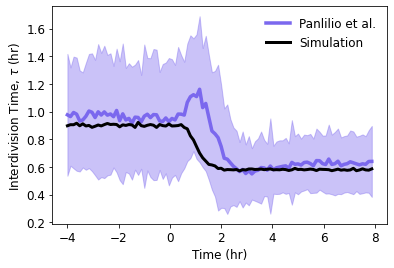

In [ ]:
plt.rc('font', size=12) #controls default text size
plt.rc('legend', fontsize=12) #fontsize of the legend
fig = plt.figure()

plt.plot(timeExp, tauExp_ave, label='Panlilio et al.', linewidth=3.5, color='mediumslateblue')
plt.fill_between(timeExp, tauExp_ave - tauExp_std, tauExp_ave + tauExp_std, alpha=0.4, color='mediumslateblue')
plt.plot(time4+0.6, tau_ave_inverse, color='k', linewidth=3, label='Simulation')
plt.xlabel('Time (hr)')
plt.ylabel('Interdivision Time, $\u03C4$ (hr)')
plt.legend(frameon=False)
plt.show()
# fig.savefig('Figures/Size Control Paper/panlilio-tau-pptx.pdf', dpi=300, bbox_inches='tight')

Plotting $\Delta$

In [ ]:
# removing zeros from deltaV data and appending into one column
deltaV_clean = pd.DataFrame(columns=['t','delta V'])
for x in range(replicates):

    delta_cut = df_concatDelta.loc[(df_concatDelta[str(x)] > 0), ['t',str(x)]] # removing zeros
    delta_cut = delta_cut.rename(columns={str(x):'delta V'}).reset_index(drop=True) # renaming column so data can be appended to existing 'delta V' column
    delta_cut = delta_cut.drop(0) # removes first row becuase value is not accurate due to random start volume
    deltaV_clean = deltaV_clean.append(delta_cut).reset_index(drop=True) # appending and reindexing

In [ ]:
n_bins = 100 # number of bins for averaging
t_min = 4 - 0.6 # selecting time window for analysis
t_max = 16 - 0.6

time = np.linspace(t_min,t_max,n_bins+1)
deltaV_ave = np.zeros(len(time))
deltaV_std = np.zeros(len(time))
n_points = len(time)

i=0
while i < n_points-1:
    deltaV_x = deltaV_clean.loc[(deltaV_clean['t'] > time[i]) & (deltaV_clean['t'] < time[i+1]), ['delta V']]
    deltaV_ave[i] = np.mean(deltaV_x)
    deltaV_std[i] = np.std(deltaV_x)
    i+=1

# changing time range to match plot from paper
time4 = time[0:-1] - t_shift # removing last timepoint becuase its not binned properly

deltaV_ave_inverse = deltaV_ave[0:-1]
deltaV_std_inverse = deltaV_std[0:-1]

In [ ]:
# Experimental

n_bins = 100 # number of bins for averaging
# set time range of analysis
t_min = -4
t_max = 8

timeExp = np.linspace(t_min,t_max,n_bins+1)
deltaExp_ave = np.zeros(len(timeExp))
deltaExp_std = np.zeros(len(timeExp))
n_points = len(timeExp)

i=0
while i < n_points-1:
    delta_x = df_Data.loc[(df_Data['t1Trans']/60 > timeExp[i]) & (df_Data['t1Trans']/60 < timeExp[i+1]), ['delta']]
    deltaExp_ave[i] = np.mean(delta_x)
    deltaExp_std[i] = np.std(delta_x)
    i+=1

# removing last timepoint becuase its not binned properly
timeExp = timeExp[0:-1]
deltaExp_ave = deltaExp_ave[0:-1]
deltaExp_std = deltaExp_std[0:-1]

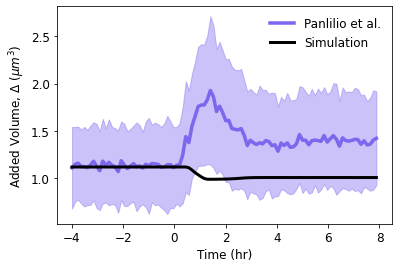

In [ ]:
plt.rc('font', size=12) #controls default text size
plt.rc('legend', fontsize=12) #fontsize of the legend
fig = plt.figure()

plt.plot(timeExp, deltaExp_ave, label='Panlilio et al.', linewidth=3.5, color='mediumslateblue')
plt.fill_between(timeExp, deltaExp_ave - deltaExp_std, deltaExp_ave + deltaExp_std, alpha=0.4, color='mediumslateblue')
plt.plot(time4+0.6, deltaV_ave_inverse, color='k', linewidth=3, label='Simulation')
plt.xlabel('Time (hr)')
plt.ylabel('Added Volume, $\Delta$ ($\mu m^3$)')
plt.legend(frameon=False)
plt.show()
# fig.savefig('Figures/Size Control Paper/panlilio-delta-pptx.pdf', dpi=300, bbox_inches='tight')

Plotting $V_0$

In [ ]:
# removing zeros from tau data and appending into one column
V0_clean = pd.DataFrame(columns=['t','V_0'])
for x in range(replicates):

    V0_cut = df_concatV0.loc[(df_concatV0[str(x)] > 0), ['t',str(x)]] # removing zeros
    V0_cut = V0_cut.rename(columns={str(x):'V_0'}).reset_index(drop=True) # renaming column so data can be appended to existing 'tau' column
    V0_cut = V0_cut.drop(0) # removes first row becuase value is not accurate due to random start volume
    V0_cut = V0_cut.drop(len(V0_cut)) # remove last row because point has no corresponding deltaV
    V0_clean = V0_clean.append(V0_cut).reset_index(drop=True) # appending and reindexing

Plotting $\Delta V / V_0$

In [ ]:
# calculating deltaV / V0
V_ratio = pd.DataFrame(deltaV_clean['delta V'] / V0_clean['V_0'], columns=['V ratio']) # pairing previous timepoint V0 with current timepoint deltaV (matching corresponding birth and division datapoints)
Vratio_df = pd.concat([deltaV_clean['t'],V_ratio], axis=1, join='inner')

In [ ]:
n_bins = 100 # number of bins for averaging
t_min = 4 - 0.6
t_max = 16 - 0.6

time = np.linspace(t_min,t_max,n_bins+1)
Vratio_ave = np.zeros(len(time))
Vratio_std = np.zeros(len(time))
n_points = len(time)

i=0
while i < n_points-1:
    Vratio_i = Vratio_df.loc[(Vratio_df['t'] > time[i]) & (Vratio_df['t'] < time[i+1]), ['V ratio']]
    Vratio_ave[i] = np.mean(Vratio_i)
    Vratio_std[i] = np.std(Vratio_i)
    i+=1

# changing time range to match plot from paper
time4 = time[0:-1] - t_shift # removing last timepoint becuase its not binned properly

Vratio_ave_inverse = Vratio_ave[0:-1]
Vratio_std_inverse = Vratio_std[0:-1]

In [ ]:
# experimental

n_bins = 80 # number of bins for averaging
# set time range of analysis
t_min = -4
t_max = 8

timeExp = np.linspace(t_min,t_max,n_bins+1)
ratio_ave = np.zeros(len(timeExp))
ratio_std = np.zeros(len(timeExp))
n_points = len(timeExp)

i=0
while i < n_points-1:
    ratio_x = df_Data.loc[(df_Data['t1Trans']/60 > timeExp[i]) & (df_Data['t1Trans']/60 < timeExp[i+1]), ['ratio']]
    ratio_ave[i] = np.mean(ratio_x)
    ratio_std[i] = np.std(ratio_x)
    i+=1

# removing last timepoint becuase its not binned properly
timeExp = timeExp[0:-1]
ratio_ave = ratio_ave[0:-1]
ratio_std = ratio_std[0:-1]

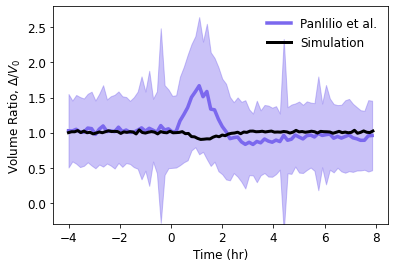

In [ ]:
plt.rc('font', size=12) #controls default text size
plt.rc('legend', fontsize=12) #fontsize of the legend
fig = plt.figure()

plt.plot(timeExp, ratio_ave, label='Panlilio et al.', linewidth=3.5, color='mediumslateblue')
plt.fill_between(timeExp, ratio_ave - ratio_std, ratio_ave + ratio_std, alpha=0.4, color='mediumslateblue')
plt.plot(time4+0.6, Vratio_ave_inverse, color='k', linewidth=3, label='Simulation')
plt.xlabel('Time (hr)')
plt.ylabel('Volume Ratio, $\Delta / V_0$')
plt.legend(frameon=False)
plt.ylim(-0.3,2.8)
plt.show()
# fig.savefig('Figures/Size Control Paper/panlilio-volRatio-pptx.pdf', dpi=300, bbox_inches='tight')

### Figure 3b

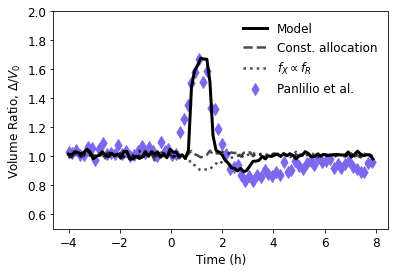

In [ ]:
plt.rc('font', size=12) #controls default text size
plt.rc('legend', fontsize=12) #fontsize of the legend
fig = plt.figure()

plt.scatter(timeExp, ratio_ave, marker='d', s=70, label='Panlilio et al.', color='mediumslateblue')
plt.plot(time4+0.6, Vratio_ave_reg, color='k', linewidth=3, label='Model')
plt.plot(time4+0.6, Vratio_ave_const, color='k', linewidth=2.5, linestyle='--', alpha=0.7, label='Const. allocation')
plt.plot(time4+0.6, Vratio_ave_inverse, color='k', linewidth=2.5, linestyle=':', alpha=0.7, label='$f_X \propto f_R$')
plt.xlabel('Time (h)')
plt.ylabel('Volume Ratio, $\Delta / V_0$')
plt.legend(frameon=False)
plt.ylim(0.5,2)
plt.show()
# fig.savefig('Figures/Size Control Paper/panlilio-volRatio-revision-nodeg.pdf', dpi=300, bbox_inches='tight')

### Figure 3c

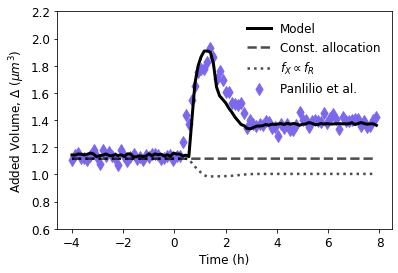

In [ ]:
plt.rc('font', size=12) #controls default text size
plt.rc('legend', fontsize=12) #fontsize of the legend
fig = plt.figure()

plt.scatter(timeExp, deltaExp_ave, marker='d', s=70, label='Panlilio et al.', color='mediumslateblue')
plt.plot(time4+0.6, deltaV_ave_reg, color='k', linewidth=3, label='Model')
plt.plot(time4+0.6, deltaV_ave_const, color='k', linewidth=2.5, linestyle='--', alpha=0.7, label='Const. allocation')
plt.plot(time4+0.6, deltaV_ave_inverse, color='k', linewidth=2.5, linestyle=':', alpha=0.7, label='$f_X \propto f_R$')
plt.xlabel('Time (h)')
plt.ylabel('Added Volume, $\Delta$ ($\mu m^3$)')
plt.legend(frameon=False)
plt.ylim(0.6,2.2)
plt.show()
# fig.savefig('Figures/Size Control Paper/panlilio-delta-revision-nodeg.pdf', dpi=300, bbox_inches='tight')

### Figure 3d

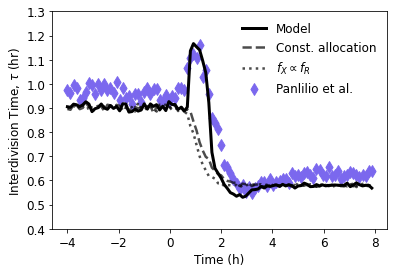

In [ ]:
plt.rc('font', size=12) #controls default text size
plt.rc('legend', fontsize=12) #fontsize of the legend
fig = plt.figure()

plt.scatter(timeExp, tauExp_ave, marker='d', s=70, label='Panlilio et al.', color='mediumslateblue')
plt.plot(time4+0.6, tau_ave_reg, color='k', linewidth=3, label='Model')
plt.plot(time4+0.6, tau_ave_const, color='k', linewidth=2.5, linestyle='--', alpha=0.7, label='Const. allocation')
plt.plot(time4+0.6, tau_ave_inverse, color='k', linewidth=2.5, linestyle=':', alpha=0.7, label='$f_X \propto f_R$')
plt.xlabel('Time (h)')
plt.ylabel('Interdivision Time, $\u03C4$ (hr)')
plt.legend(frameon=False)
plt.ylim(0.4,1.3)
plt.show()
# fig.savefig('Figures/Size Control Paper/panlilio-tau-revision-nodeg.pdf', dpi=300, bbox_inches='tight')